# Beans Disease classification: Transfer Learning

The goal is to build a robust machine learning model that is able to distinguish between diseases in the Bean plants. Beans are an important cereal food crop for Africa grown by many small-holder farmers - they are a significant source of proteins for school-age going children in East Africa.

The data is of leaf images representing 3 classes: the healthy class of images, and two disease classes including Angular Leaf Spot and Bean Rust diseases. The model should be able to distinguish between these 3 classes with high accuracy. The end goal is to build a robust, model that can be deployed on a mobile device and used in the field by a farmer.

## Environment

In [2]:
from datasets import load_dataset, concatenate_datasets

import tensorflow as tf

from keras.api.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Resizing, Lambda, RandomFlip, RandomRotation, RandomContrast
from keras.api.models import Sequential, Model
from keras.api.applications.efficientnet_v2 import preprocess_input
from keras.api.optimizers import Adam
from keras.api.callbacks import EarlyStopping
from keras.api import layers
from keras.api.applications import EfficientNetV2S
from keras.optimizers.schedules import CosineDecayRestarts
import keras

from sklearn.model_selection import train_test_split

import numpy as np

import collections

import matplotlib.pyplot as plt

import datetime

In [3]:
from importlib.metadata import version

def print_version(module_name):
    print(f"{module_name}: {version(module_name)}")

print_version("tensorflow")
print_version("keras")
print_version("scikit-learn")
print_version("numpy")

tensorflow: 2.18.0
keras: 3.8.0
scikit-learn: 1.6.1
numpy: 1.26.4


In [4]:
!nvidia-smi

Sun Mar  9 16:14:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


### Determinism

Make sure every run is deterministic so that results are reproducible and improvements verified.

In [6]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

In [7]:
start_time = datetime.datetime.now()

## Loading data

Load everything so that we can split it ourselves.

In [8]:
ds = load_dataset("AI-Lab-Makerere/beans")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [9]:
ds_all = concatenate_datasets([ds["train"], ds["validation"], ds["test"]])
ds_all

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1295
})

In [10]:
class_names = ["angular_leaf_spot", "bean_rust", "healthy"]
n_classes = len(class_names)

# Same ratio as in original dataset
train_size = 1034
val_size = 133
test_size = 128

batch_size = 32

## Stratified split

Original split caused huge difference in performance of model when doing predictions with validation and test data sets.

In [11]:
train_data, temp_data, train_labels, temp_labels = train_test_split(
    ds_all["image"],
    ds_all["labels"],
    train_size=train_size,
    random_state=42,
    shuffle=True,
    stratify=ds_all["labels"],
)

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data,
    temp_labels,
    train_size=val_size,
    random_state=42,
    shuffle=True,
    stratify=temp_labels,
)

ds_train = tf.data.Dataset.from_tensor_slices((np.array(train_data), np.array(train_labels)))
ds_valid = tf.data.Dataset.from_tensor_slices((np.array(val_data), np.array(val_labels)))
ds_test = tf.data.Dataset.from_tensor_slices((np.array(test_data), np.array(test_labels)))

Make sure original ratio is preserved.

In [12]:
print(f"train set {len(list(ds_train))}")
print(f"validation set {len(list(ds_valid))}")
print(f"test set {len(list(ds_test))}")

train set 1034
validation set 133
test set 128


Make sure that ratio of different classes is same across datasets

In [13]:
def count_labels(dataset):
    label_counts = collections.Counter()

    for _, label in dataset:
        label_counts[label.numpy()] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}

    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

print(count_labels(ds_train))
print(count_labels(ds_valid))
print(count_labels(ds_test))

{0: 0.33365570599613154, 1: 0.3365570599613153, 2: 0.32978723404255317}
{0: 0.3308270676691729, 1: 0.3383458646616541, 2: 0.3308270676691729}
{0: 0.3359375, 1: 0.3359375, 2: 0.328125}


## Preprocess and Augmentation

In [14]:
resizing_and_augmentation = Sequential([
    Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    RandomFlip(mode="horizontal", seed=42),
    RandomRotation(factor=0.05, seed=42),
    RandomContrast(factor=0.2, seed=42)
])

## Input pipeline

Preprocess and augmentation is part of input pipeline because it is faster.

When processing power / time is not an issue, I recommend moving it to model.
Apart from cleaner and more flexible code, having it as part of model actually improved performance a bit.

In [15]:
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(len(train_data))
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [16]:
ds_valid = ds_valid.cache()
ds_valid = ds_valid.batch(batch_size)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [17]:
ds_test = ds_test.cache()
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Verify that augmentation produces photos similar to original dataset (too much augmentation might cause model not to generalize well).

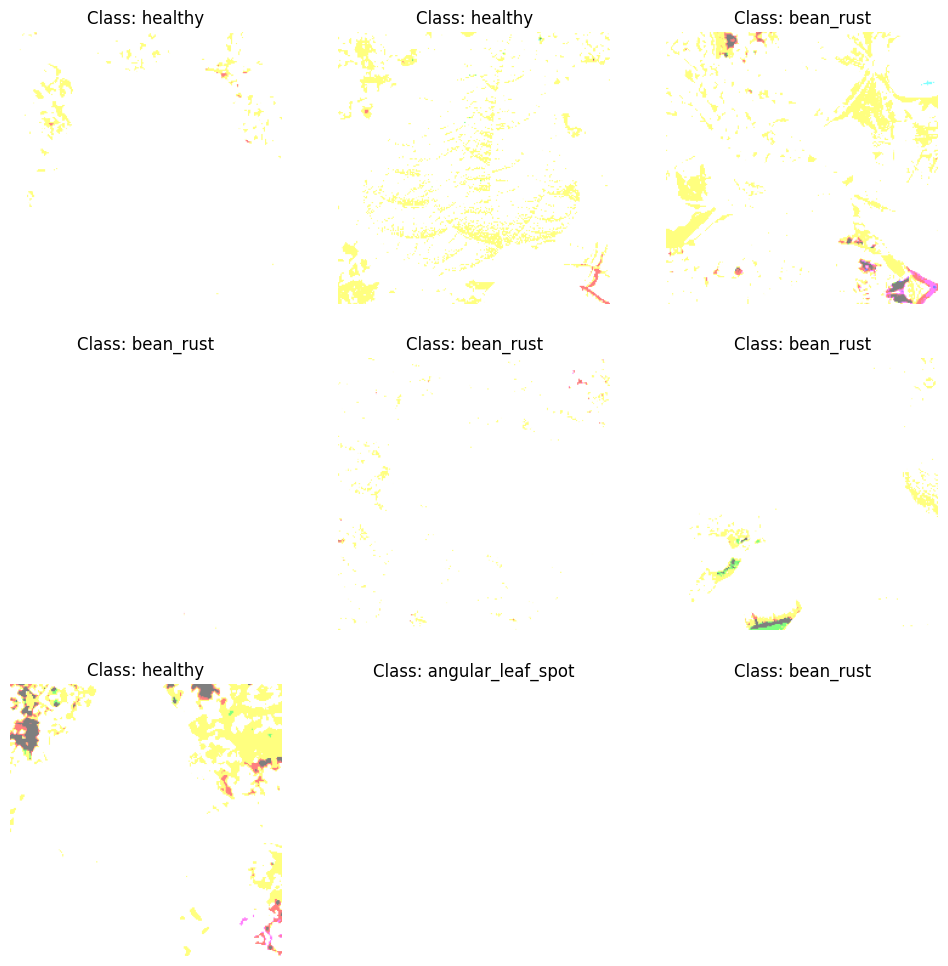

In [18]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in ds_train.take(1):
    X_batch = resizing_and_augmentation(X_batch)
    X_batch = preprocess_input(X_batch)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

## Base model with pre-trained weights

In [19]:
# To reset layer names when doing multiple runs
tf.keras.backend.clear_session()

Xception with SGD optimizer converges pretty quickly with good results (other models needed more time with lower learning to achieve same performance).

This version mostly follows example from [Machine Learning Notebooks, 3rd edition](https://github.com/ageron/handson-ml3).

In [20]:
base_model = EfficientNetV2S(
    input_shape=(224, 224, 3), include_top=False
)
base_model.trainable = False

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


This simple top performs surprisingly well (however Dropout is needed for overfitting).

Adding additional Dense layer, Batch Normalization layer and/or Dropout layer required more hyperparameter tuning to get similar performance (but never as good.).

In [21]:
inputs = Input(shape=(None, None, 3))
x = resizing_and_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(n_classes, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

## Initial training without touching base model

Early stopping is here in this version more to make sure that the best weights are used.

In different versions where we needed to train for longer, it also helped us to end early when there was not progress (and avoid overfitting).

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode="min")

SGD works surprisingly well - doesn't use as much memory, converges fast and with good results.

Adam required more training and had bigger memory footprint with much smaller learning rate (and/or learning rate scheduler).

In [23]:
optimizer = Adam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(ds_train, validation_data=ds_valid, epochs=20, callbacks=[early_stopping])

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 45s 510ms/step - accuracy: 0.4742 - loss: 1.0279 - val_accuracy: 0.8346 - val_loss: 0.5884
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.7304 - loss: 0.6667 - val_accuracy: 0.8647 - val_loss: 0.4393
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.8034 - loss: 0.5261 - val_accuracy: 0.8947 - val_loss: 0.3695
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8505 - loss: 0.4396 - val_accuracy: 0.9023 - val_loss: 0.3271
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.8065 - loss: 0.4848 - val_accuracy: 0.9173 - val_loss: 0.2989
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.8747 - loss: 0.3685 - val_accuracy: 0.9098 - val_loss: 0.2804
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.8870 - loss: 0.3438 - val_accuracy: 0.9098 - val_loss: 0.2672
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.8607 - loss: 0.3607 - val_accuracy: 

In [24]:
restored_epoch = early_stopping.best_epoch + 1 # EarlyStopping uses 0-based indexing (from observation)
restored_epoch

20

In [25]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

4/4 - 1s - 187ms/step - accuracy: 0.9375 - loss: 0.1780
0.9375


In [26]:
acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']

loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

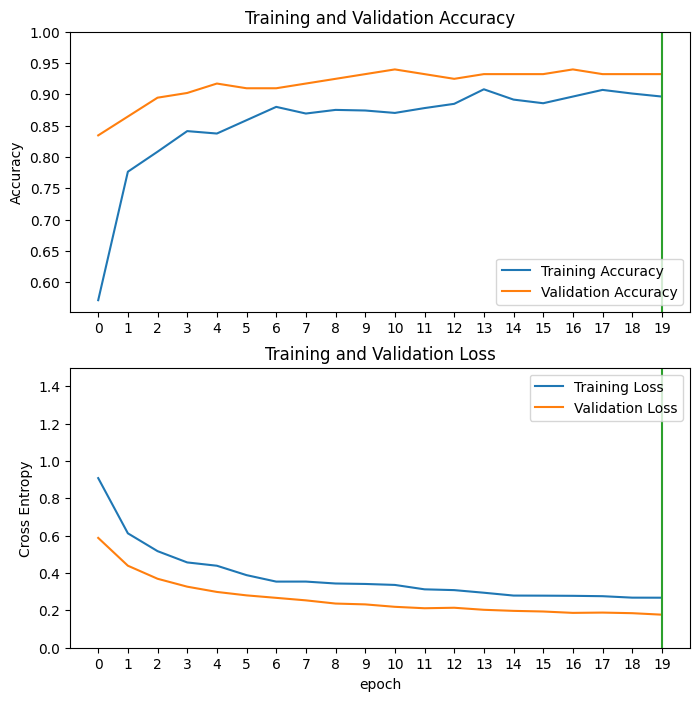

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xticks(range(100))
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([restored_epoch-1,restored_epoch-1],
         plt.ylim(), label='Best weights')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks(range(100))
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.plot([restored_epoch-1,restored_epoch-1],
         plt.ylim(), label='Best weights')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

Same as before - early stopping is used mostly to get best weights.

Using bigger number for patience as we fine tune for longer.

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode="min")

In [29]:
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-4,  # Adjust if needed
    first_decay_steps=20,        # Increased from 10
    t_mul=2.0,                   # You can try increasing this
    m_mul=1.0,                   # You can experiment with values < 1.0
    alpha=0.0                    # Adjust if needed
)

Unfreeze some layers from base_model for fine tuning. We also need to use much lower learning rate so that existing weights are not completely destroyed.

In [35]:
base_model.trainable = True

for layer in base_model.layers[:-226]:
    layer.trainable = False

optimizer = Adam(learning_rate=lr_schedule)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history_fine = model.fit(ds_train, validation_data=ds_valid, epochs=100, callbacks=[early_stopping])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 72s 531ms/step - accuracy: 0.7734 - loss: 0.5258 - val_accuracy: 0.9699 - val_loss: 0.1538
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.9551 - loss: 0.1627 - val_accuracy: 0.9549 - val_loss: 0.1274
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - accuracy: 0.9659 - loss: 0.1264 - val_accuracy: 0.9850 - val_loss: 0.0787
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.9773 - loss: 0.0821 - val_accuracy: 0.9925 - val_loss: 0.0729
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 335ms/step - accuracy: 0.9821 - loss: 0.0724 - val_accuracy: 0.9925 - val_loss: 0.0526
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.9857 - loss: 0.0425 - val_accuracy: 0.9850 - val_loss: 0.0482
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.9952 - loss: 0.0232 - val_accuracy: 0.9925 - val_loss: 0.0397
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.9941 - loss: 0.0294 - 

In [36]:
restored_epoch_fine = early_stopping.best_epoch + 1 # EarlyStopping uses 0-based indexing (from observation)
restored_epoch_fine

12

In [37]:
train_loss, train_acc = model.evaluate(ds_train, verbose=2)
print(train_acc)

33/33 - 5s - 150ms/step - accuracy: 1.0000 - loss: 0.0020
1.0


In [38]:
val_loss, val_acc = model.evaluate(ds_valid, verbose=2)
print(val_acc)

5/5 - 1s - 128ms/step - accuracy: 0.9850 - loss: 0.0274
0.9849624037742615


In [39]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

4/4 - 1s - 158ms/step - accuracy: 0.9766 - loss: 0.0978
0.9765625


Remove training that was not used.

In [40]:
acc_history = acc_history[:restored_epoch]
val_acc_history = val_acc_history[:restored_epoch]

loss_history = loss_history[:restored_epoch]
val_loss_history = val_loss_history[:restored_epoch]

In [41]:
acc_history += history_fine.history['accuracy']
val_acc_history += history_fine.history['val_accuracy']

loss_history += history_fine.history['loss']
val_loss_history += history_fine.history['val_loss']

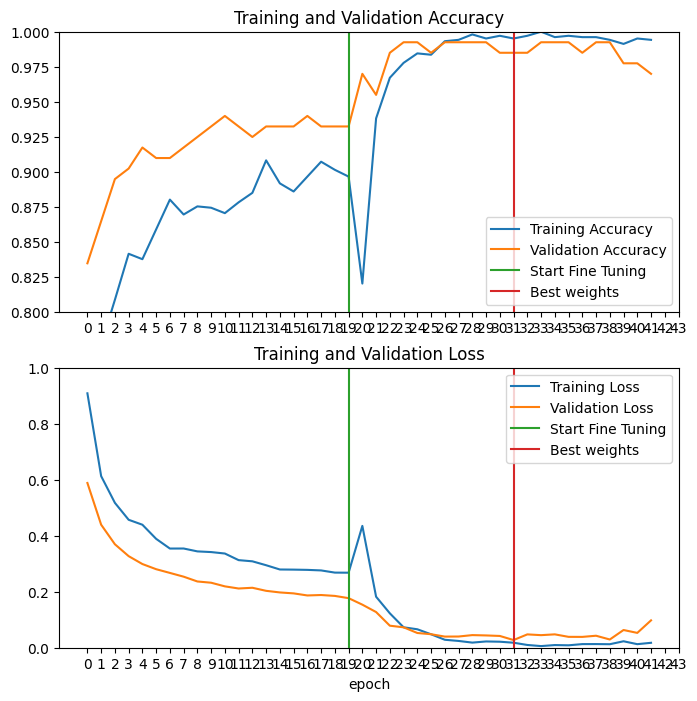

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xticks(range(100))
plt.ylim([0.8, 1])
plt.plot([restored_epoch-1,restored_epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([restored_epoch + restored_epoch_fine-1, restored_epoch + restored_epoch_fine-1],
         plt.ylim(), label='Best weights')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xticks(range(100))
plt.ylim([0, 1.0])
plt.plot([restored_epoch-1,restored_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([restored_epoch + restored_epoch_fine-1, restored_epoch + restored_epoch_fine-1],
         plt.ylim(), label='Best weights')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Save model

In [43]:
model.save("beans_disease_classification_transfer_learning.keras")

In [44]:
duration = datetime.datetime.now() - start_time
print(duration)

0:12:28.223761
